In [1]:
import torch
import torch.nn as nn
from torch import nn, optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# Load the data
file_path = "./static_data_summary.csv"
data = pd.read_csv(file_path)

# Extract the 'totpop' column
totpop = data['totpop'].values

# Extract the real travel demand data from ridesouring file 
ridesourcing_file_path = "./Ridesourcing_CensusCount_ALL_0_Filled.csv"
ridesourcing_data = pd.read_csv(ridesourcing_file_path)

# Aggregate travel demand data by summing all time intervals for each census tract
travel_demand = ridesourcing_data.drop(columns=['index']).sum(axis=1).values

# Convert 'totpop' to a tensor and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
populations = torch.tensor(totpop, dtype=torch.float32).to(device)
travel_demand_tensor = torch.tensor(travel_demand, dtype=torch.float32).to(device)

In [3]:
# Extract features from the data
features = data[['SerHourBusRoutes', 'SerHourRailRoutes', 'BusStopDen', 'RailStationDen', 'popden', 'pctmale', 
                 'pctbachelor', 'young2', 'pcthisp', 'carown', 'pctlowinc', 'pctmidinc', 'pcthighinc', 
                 'pctsinfam2', 'CrimeDen', 'RdNetwkDen', 'InterstDen']].values

'''
# Normalize the data
# Min-max normalization for features, populations, and travel demand 
features_min = np.min(features, axis=0)
features_max = np.max(features, axis=0)
features_normalized = (features - features_min) / (features_max - features_min)

pop_min = np.min(totpop)
pop_max = np.max(totpop)
populations_normalized = (totpop - pop_min) / (pop_max - pop_min)

travel_demand_min = np.min(travel_demand)
travel_demand_max = np.max(travel_demand)
travel_demand_normalized = (travel_demand - travel_demand_min) / (travel_demand_max - travel_demand_min)
'''

'\n# Normalize the data\n# Min-max normalization for features, populations, and travel demand \nfeatures_min = np.min(features, axis=0)\nfeatures_max = np.max(features, axis=0)\nfeatures_normalized = (features - features_min) / (features_max - features_min)\n\npop_min = np.min(totpop)\npop_max = np.max(totpop)\npopulations_normalized = (totpop - pop_min) / (pop_max - pop_min)\n\ntravel_demand_min = np.min(travel_demand)\ntravel_demand_max = np.max(travel_demand)\ntravel_demand_normalized = (travel_demand - travel_demand_min) / (travel_demand_max - travel_demand_min)\n'

In [4]:
# Convert to tensors
X_train = torch.tensor(features, dtype=torch.float32).to(device)
y_train = torch.tensor(travel_demand, dtype=torch.float32).to(device).view(-1, 1)
populations_tensor = torch.tensor(totpop, dtype=torch.float32).to(device)

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
'''
class DeeperNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(DeeperNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.output_relu = nn.ReLU()  # Ensures non-negative outputs

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.output_relu(out)  # Apply ReLU to the output
        return out
'''

'\nclass DeeperNN(nn.Module):\n    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):\n        super(DeeperNN, self).__init__()\n        self.fc1 = nn.Linear(input_size, hidden_size1)\n        self.relu1 = nn.ReLU()\n        self.fc2 = nn.Linear(hidden_size1, hidden_size2)\n        self.relu2 = nn.ReLU()\n        self.fc3 = nn.Linear(hidden_size2, hidden_size3)\n        self.relu3 = nn.ReLU()\n        self.fc4 = nn.Linear(hidden_size3, output_size)\n        self.output_relu = nn.ReLU()  # Ensures non-negative outputs\n\n    def forward(self, x):\n        out = self.fc1(x)\n        out = self.relu1(out)\n        out = self.fc2(out)\n        out = self.relu2(out)\n        out = self.fc3(out)\n        out = self.relu3(out)\n        out = self.fc4(out)\n        out = self.output_relu(out)  # Apply ReLU to the output\n        return out\n'

In [6]:
# Computes a monotonicity penalty if the predictions do not uphold monotonic constraint 
def calculate_monotonicity_penalty(preds, populations, device):
    penalty = torch.zeros(1, device=device)
    for i in range(1, len(preds)):
        if populations[i] > populations[i - 1] and preds[i] < preds[i - 1]:
            penalty += torch.abs(preds[i] - preds[i - 1])
    return penalty

# Loss function: combines the MSE loss with the monotonicity penalty 
def calculate_loss(y_pred, label, criterion, lam, device, populations):
    cost1 = criterion(y_pred, label).double()
    monotonicity_penalty = calculate_monotonicity_penalty(y_pred, populations, device)
    cost = (1 - lam) * cost1 + gama* lam * monotonicity_penalty # lam controls the trade-off between MSE loss and monotonicity penalty 
    return cost, cost1, monotonicity_penalty

In [7]:
# Define model, criterion, and optimizer
input_size = X_train.shape[1]
hidden_size = 50
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size).to(device)
'''
hidden_size1 = 128
hidden_size2 = 64
hidden_size3 = 32
model = DeeperNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size).to(device)
'''
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lam = 0.5

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(X_train)
    
    # Calculate loss
    loss, cost1, monotonicity_penalty = calculate_loss(
        y_pred, y_train, criterion, lam, device, populations_tensor
    )
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Print loss for monitoring
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Cost1: {cost1.item()}, Monotonicity Penalty: {monotonicity_penalty.item()}')

print("Training completed")

Epoch [1/100], Loss: 7275843072.0, Cost1: 14551541760.0, Monotonicity Penalty: 144880.0
Epoch [2/100], Loss: 7270458368.0, Cost1: 14540766208.0, Monotonicity Penalty: 150721.890625
Epoch [3/100], Loss: 7265054208.0, Cost1: 14529951744.0, Monotonicity Penalty: 156633.625
Epoch [4/100], Loss: 7259625472.0, Cost1: 14519088128.0, Monotonicity Penalty: 162511.796875
Epoch [5/100], Loss: 7254174720.0, Cost1: 14508180480.0, Monotonicity Penalty: 168455.484375
Epoch [6/100], Loss: 7248698880.0, Cost1: 14497223680.0, Monotonicity Penalty: 174451.265625
Epoch [7/100], Loss: 7243202048.0, Cost1: 14486223872.0, Monotonicity Penalty: 180495.390625
Epoch [8/100], Loss: 7237683712.0, Cost1: 14475181056.0, Monotonicity Penalty: 186583.953125
Epoch [9/100], Loss: 7232141824.0, Cost1: 14464091136.0, Monotonicity Penalty: 192714.65625
Epoch [10/100], Loss: 7226578944.0, Cost1: 14452959232.0, Monotonicity Penalty: 198890.625
Epoch [11/100], Loss: 7220996096.0, Cost1: 14441787392.0, Monotonicity Penalty: 2

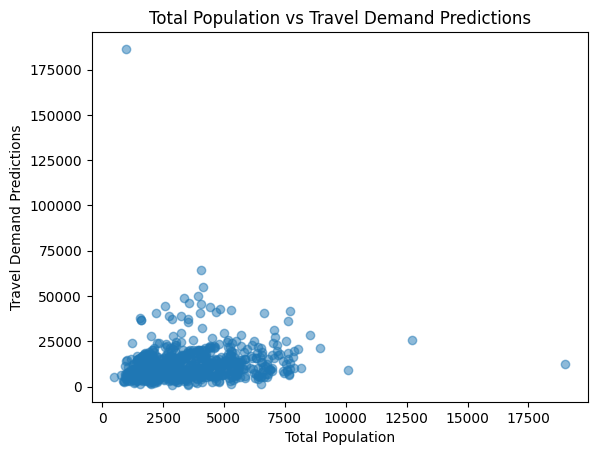

In [16]:
# Convert predictions back to CPU and numpy for plotting
y_pred_np = y_pred.cpu().detach().numpy()
populations_np = populations_tensor.cpu().detach().numpy()

# Scatter plot
plt.scatter(populations_np, y_pred_np, alpha=0.5)
plt.xlabel('Total Population')
plt.ylabel('Travel Demand Predictions')
plt.title('Total Population vs Travel Demand Predictions')
plt.show()

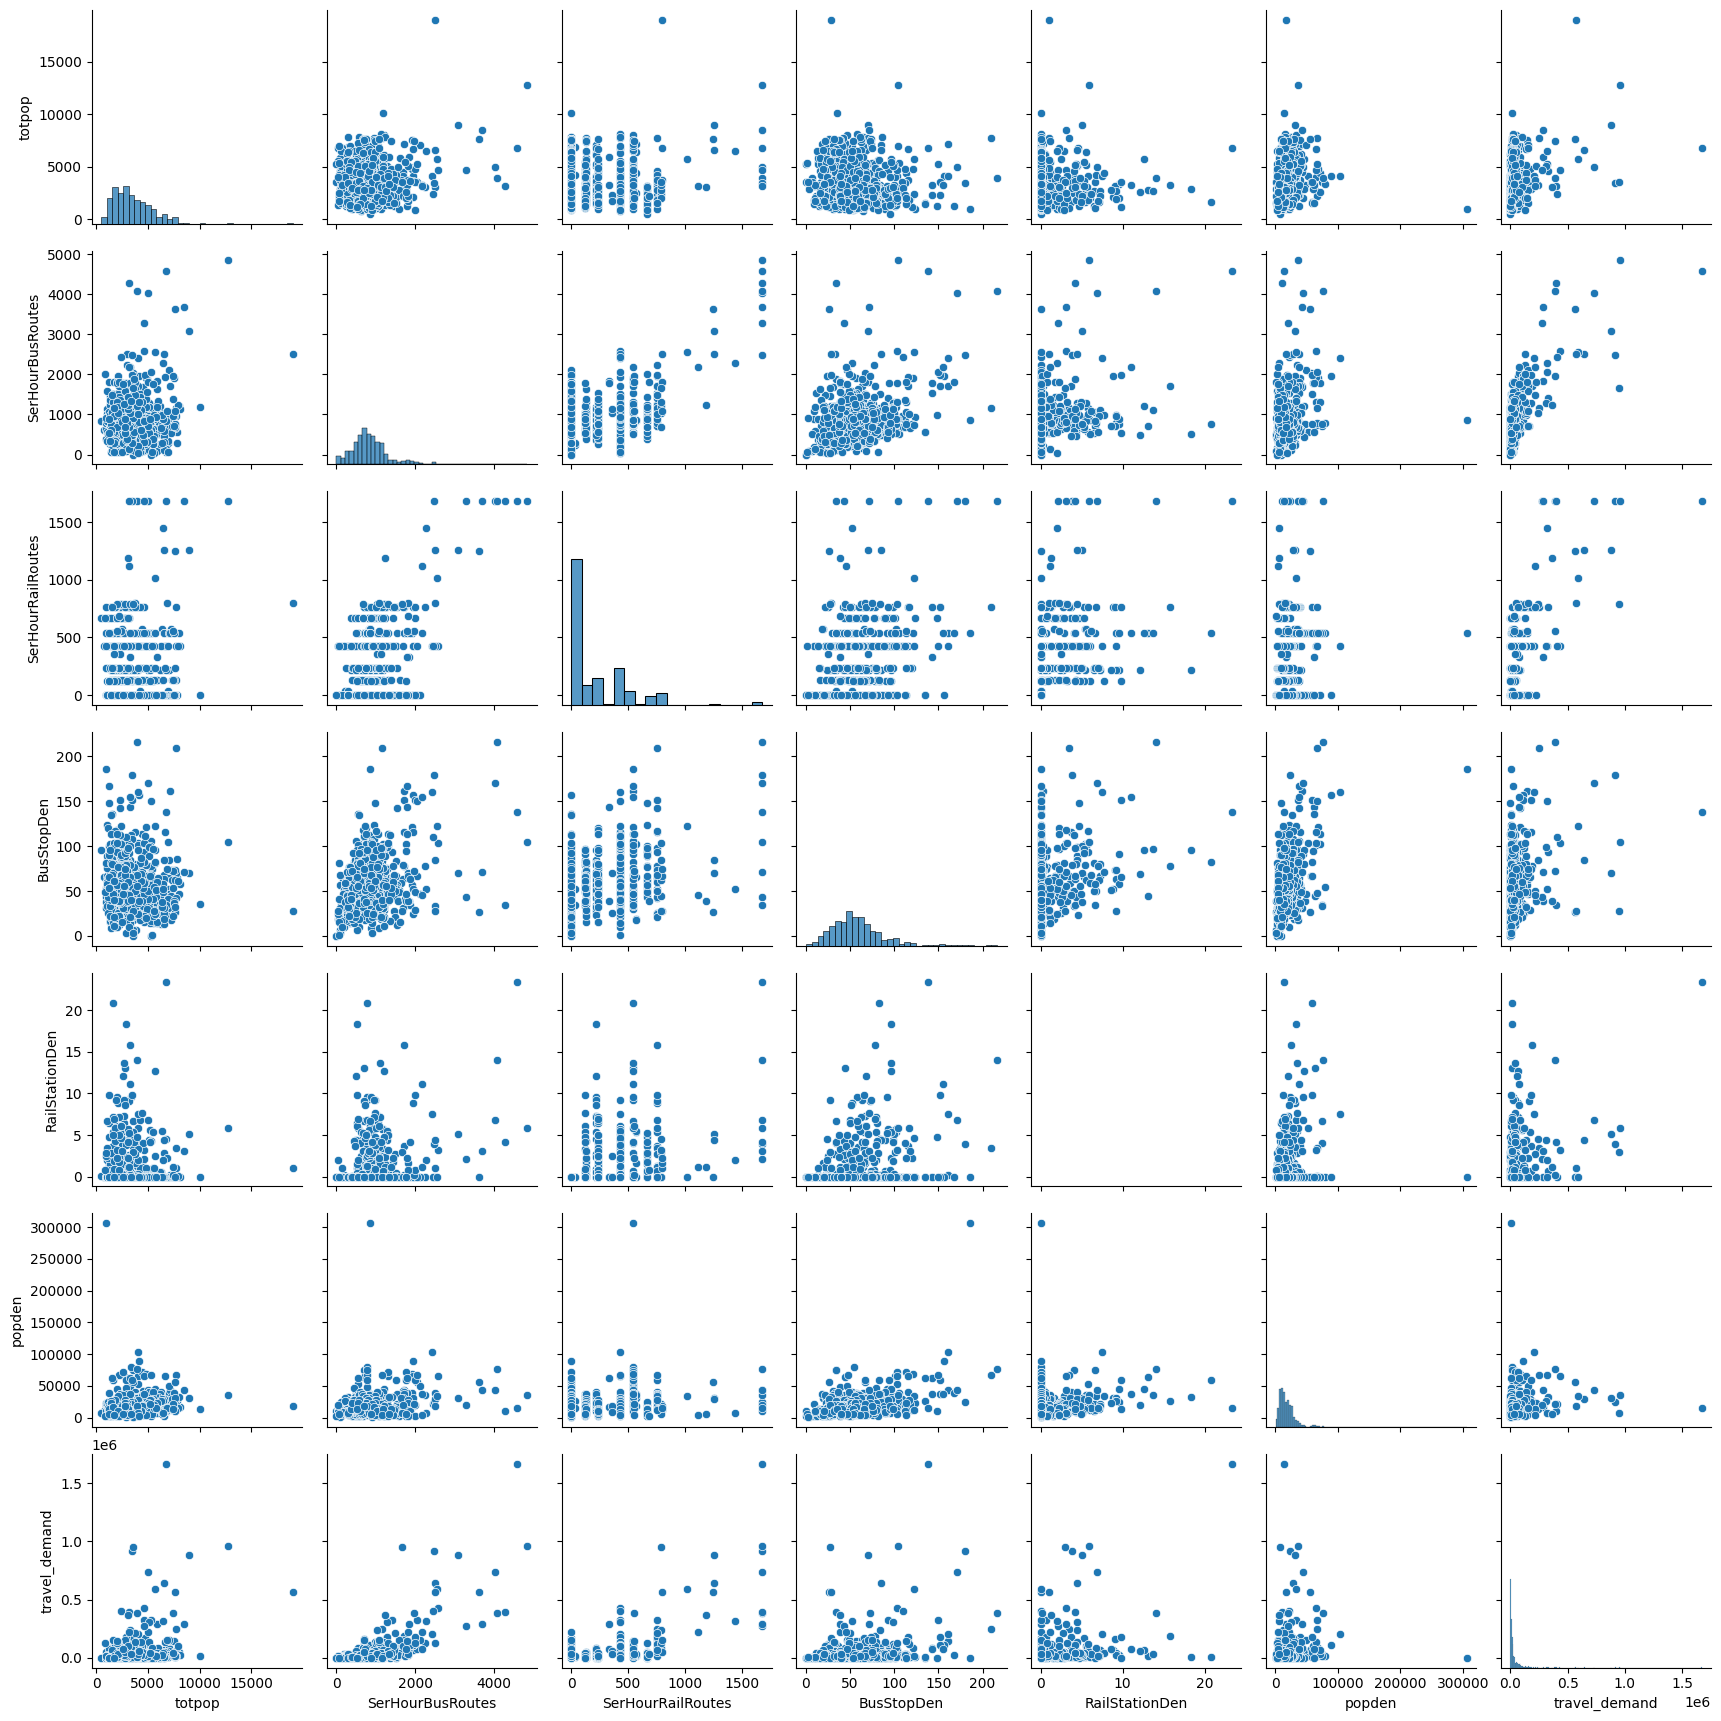

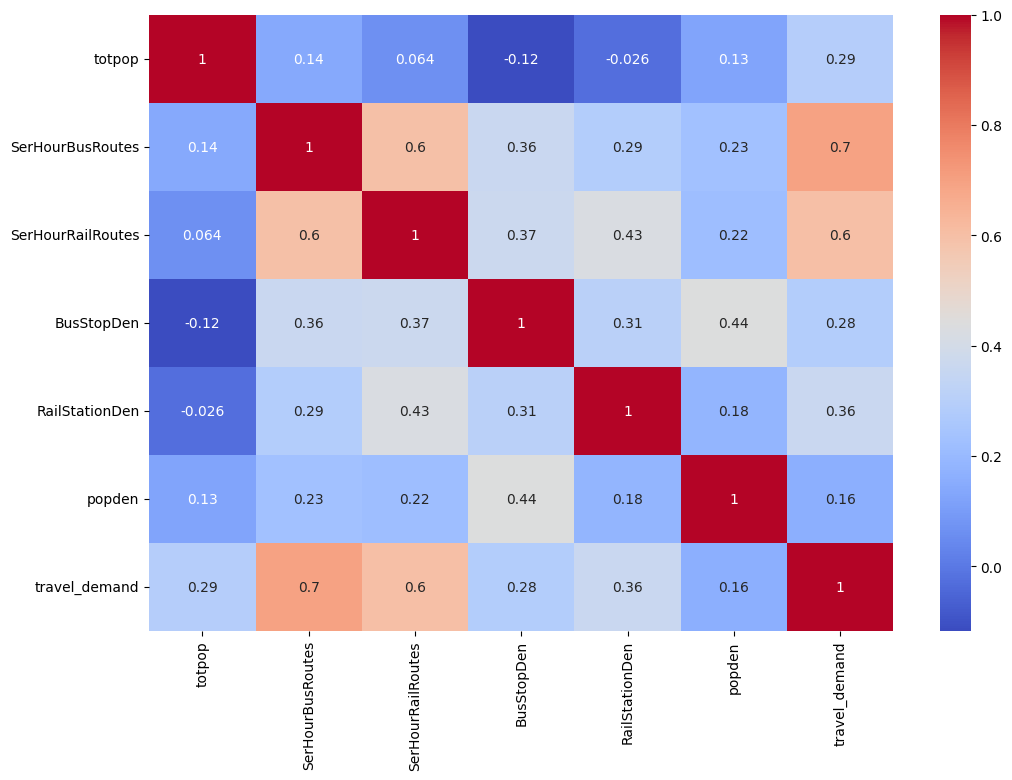

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(file_path)

# Extract the travel demand data
ridesourcing_data = pd.read_csv(ridesourcing_file_path)
travel_demand = ridesourcing_data.drop(columns=['index']).sum(axis=1).values
data['travel_demand'] = travel_demand

# Pairplot to visualize relationships between features and travel demand
sns.pairplot(data[['totpop', 'SerHourBusRoutes', 'SerHourRailRoutes', 'BusStopDen', 'RailStationDen', 'popden', 'travel_demand']])
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data[['totpop', 'SerHourBusRoutes', 'SerHourRailRoutes', 'BusStopDen', 'RailStationDen', 'popden', 'travel_demand']].corr(), annot=True, cmap='coolwarm')
plt.show()

In [106]:
# Check for NA values in both datasets
print("Missing values in static_data_summary.csv:")
print(data.isnull().sum())

print("\nMissing values in Ridesourcing_CensusCount_ALL_0_Filled.csv:")
print(ridesourcing_data.isnull().sum())

Missing values in static_data_summary.csv:
Unnamed: 0           0
geoid10              0
SerHourBusRoutes     0
SerHourRailRoutes    0
BusStopDen           0
RailStationDen       0
popden               0
pctmale              0
pctbachelor          0
young2               0
pctwhite             0
pctblack             0
pcthisp              0
carown               0
pctlowinc            0
pctmidinc            0
pcthighinc           0
pctsinfam2           0
CrimeDen             0
RdNetwkDen           0
InterstDen           0
totpop               0
travel_demand        0
dtype: int64

Missing values in Ridesourcing_CensusCount_ALL_0_Filled.csv:
index                  0
2018-11-01 00:00:00    0
2018-11-01 01:00:00    0
2018-11-01 02:00:00    0
2018-11-01 03:00:00    0
                      ..
2019-03-30 20:00:00    0
2019-03-30 21:00:00    0
2019-03-30 22:00:00    0
2019-03-30 23:00:00    0
2019-03-31 00:00:00    0
Length: 3602, dtype: int64


In [9]:
data.info()
ridesourcing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771 entries, 0 to 770
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         771 non-null    int64  
 1   geoid10            771 non-null    int64  
 2   SerHourBusRoutes   771 non-null    float64
 3   SerHourRailRoutes  771 non-null    float64
 4   BusStopDen         771 non-null    float64
 5   RailStationDen     771 non-null    float64
 6   popden             771 non-null    float64
 7   pctmale            771 non-null    float64
 8   pctbachelor        771 non-null    float64
 9   young2             771 non-null    float64
 10  pctwhite           771 non-null    float64
 11  pctblack           771 non-null    float64
 12  pcthisp            771 non-null    float64
 13  carown             771 non-null    float64
 14  pctlowinc          771 non-null    float64
 15  pctmidinc          771 non-null    float64
 16  pcthighinc         771 non